In [58]:
## Libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix, save_npz, load_npz
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Question 1

In [59]:
## Load data
gene_names = np.loadtxt('./provided_data/GeneNames.txt', dtype='str')
gene_lengths = np.loadtxt('./provided_data/GeneLengths.txt')
labels = np.loadtxt('./provided_data/labels.txt')
raw_counts = np.loadtxt('./provided_data/ReadCounts.txt')

### Part A

In [61]:
def rpkm(raw_counts, gene_lengths):
    
    """Find the normalized counts for raw_counts
    Returns: a matrix of same size as raw_counts
    """
    
    norm_counts = raw_counts.copy()
    totalReads = np.sum(norm_counts, axis=0)
    
    numGenes, numSamples = raw_counts.shape[0], raw_counts.shape[1]
    
    for m in range(numSamples):
        
        M = totalReads[m]
        
        for n in range(numGenes):
            norm_counts[n, m] = (norm_counts[n, m] * 10**9)/(M * gene_lengths[n])

    return norm_counts

def tpm(raw_counts, gene_lengths):
    """
    Find the normalized counts for raw_counts
    Returns: a matrix of same size as raw_counts
    """    
    numGenes, numSamples = raw_counts.shape[0], raw_counts.shape[1]
    norm_counts = raw_counts.copy()
    
    for n in range(numGenes):
        norm_counts[n, :] = norm_counts[n, :] / (gene_lengths[n]/10**3)
        
    scaling_factors = np.sum(norm_counts, axis = 0)
    scaling_factors = scaling_factors/1000000
      
    for m in range(numSamples):
        norm_counts[:, m] = norm_counts[:, m] / scaling_factors[m]
      
    return norm_counts

def size_factor(raw_counts):

    """
    Find the normalized counts for raw_counts
    Returns: a matrix of same size as raw_counts
    """

    norm_counts = raw_counts.copy()
    
    numGenes, numSamples = raw_counts.shape[0], raw_counts.shape[1]
    
    sizes = []
    for m in range(numSamples):

        ratios = []
        for n in range(numGenes):
            denom = np.prod(raw_counts[n, :]) ** (1/numSamples)
            ratios.append(raw_counts[n][m]/denom)

        sizes.append(np.median(ratios))
        
    for m in range(numSamples):
        norm_counts[:, m] = norm_counts[:, m] / sizes[m]
   
    return norm_counts

In [62]:
rpkm = rpkm(raw_counts, gene_lengths)
tpm = tpm(raw_counts, gene_lengths)
size_factor = size_factor(raw_counts)

### Part B

In [63]:
log_raw_counts = np.log2(raw_counts)
log_rpkm = np.log2(rpkm)
log_tpm = np.log2(tpm)
log_size_factor = np.log2(size_factor)
np.savetxt("size_factor_normalized_counts.txt", log_size_factor)

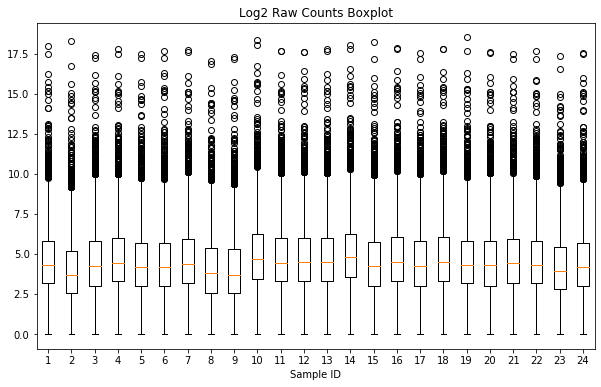

In [82]:
plt.figure(figsize=(10,6))
plt.boxplot(x=log_raw_counts)
plt.title("Log2 Raw Counts Boxplot")
plt.xlabel("Sample ID")
plt.show()

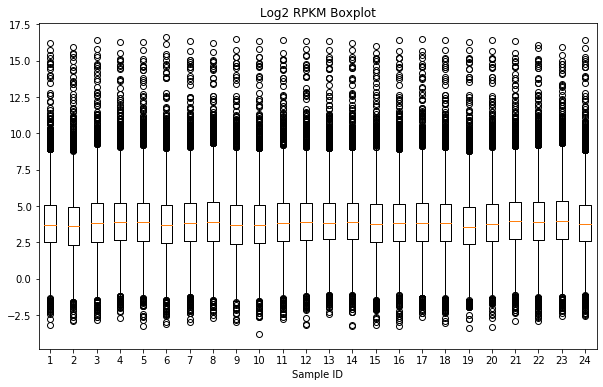

In [83]:
plt.figure(figsize=(10,6))
plt.boxplot(x=log_rpkm)
plt.title("Log2 RPKM Boxplot")
plt.xlabel("Sample ID")
plt.show()

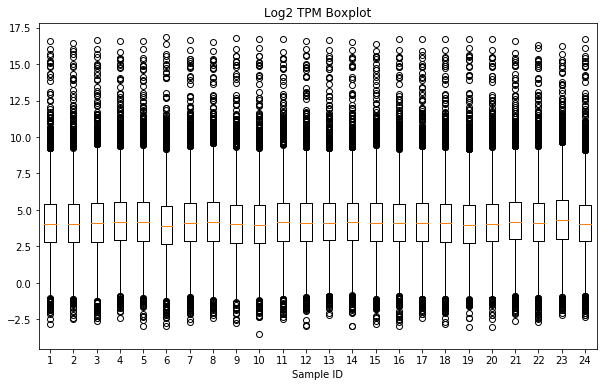

In [84]:
plt.figure(figsize=(10,6))
plt.boxplot(x=log_tpm)
plt.title("Log2 TPM Boxplot")
plt.xlabel("Sample ID")
plt.show()

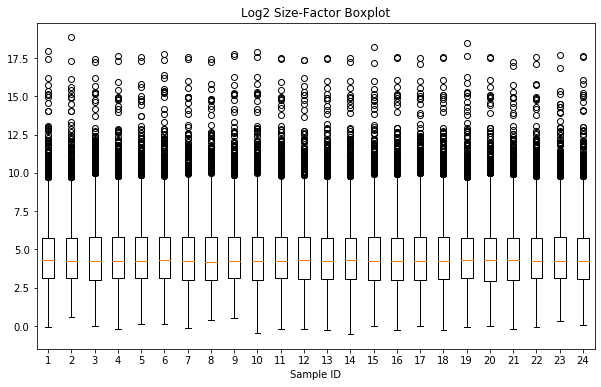

In [85]:
plt.figure(figsize=(10,6))
plt.boxplot(x=log_size_factor)
plt.title("Log2 Size-Factor Boxplot")
plt.xlabel("Sample ID")
plt.show()

### Part C

The size-factor plot seems to be the most stable in terms of not only normalizing for the mean per sample but also across samples. While the log2 boxplots for both
the size-factor, RPKM, and TPM normalizations seem to have uniform means across samples, along with their IQRs being more expansive than with the raw counts method, the size-factor plot does a better job in dealing with outliers, as can be seen with how the upper-quartile outlier points are tucked in closer to the IQR as is evident by the range of log2 counts. While the log2 raw counts seem to exhibit similar variances to the size-factor normalization plot, it is clear that the means of the raw counts method across all samples are in less agreement with each other, while for the TPM and RPKM method we see more upper/lower quartile outlier points which are absent in the size-factor method. Thus, we observe that the size-factor normalization method provides a stable normalization process across samples and genes to conduct differential gene expression experiments. 

## Question 2

In [68]:
def sample_gene_dispersion(arr):
    dispersion = np.std(arr)/np.mean(arr)
    return dispersion

def dataset_gene_dispersion(data, labels):

    ## Index case vs. control samples
    case_idxs = np.where(labels == 1)
    control_idxs = np.where(labels == 2)

    ## No. of genes, case samples, and control samples
    numGenes = len(data)
    numCases, numControls = len(case_idxs), len(control_idxs)
    
    control_samples = data[:, control_idxs]
    case_samples = data[:, case_idxs]

## Initiate separate gene exp datasets for cases & controls
#     case_samples = np.ndarray(shape=(numGenes, numCases))
#     control_samples = np.ndarray(shape=(numGenes, numCases))

#     ## Add gene exp data for case & control samples
#     for i in range(numCases):
#         case_samples[:, i] = data[:, case_idxs[i]]
#     for i in range(numControls):
#         control_samples[:, i] = data[:, control_idxs[i]] 

    ## Calc. dispersion of each gene in the case & control datasets
    
    disp_case, disp_control = np.zeros(shape=(1, numGenes)), np.zeros(shape=(1, numGenes))
    for i in range(numGenes):
        disp_case[0, i] = sample_gene_dispersion(case_samples[i, :])
        disp_control[0, i] = sample_gene_dispersion(control_samples[i, :])

    return disp_case, disp_control

def compute_log_fold(gene_names, case_data, control_data):
    
    numGenes = len(gene_names)
    gene_fold_change = []

    
    for i in range(numGenes):
        gene_fold_change.append(np.log2(case_data[i] / control_data[i]))
        
    top_scores = sorted(gene_fold_change)[::-1]
    bottom_scores = sorted(gene_fold_change)

    top_pos_genes = gene_names[np.argsort(gene_fold_change)[::-1][:10]]
    top_neg_genes = gene_names[np.argsort(gene_fold_change)[:10]]

    top_pos_gene_scores = {top_pos_genes[i]: top_scores[i] for i in range(10)}
    top_neg_gene_scores = {top_neg_genes[i]: bottom_scores[i] for i in range(10)}
    
    return gene_fold_change, top_pos_gene_scores, top_neg_gene_scores

def compute_mean_counts(data):
    mean_counts = np.mean(data, axis=1)
    return mean_counts

### Part A

In [69]:
disp_case, disp_control = dataset_gene_dispersion(size_factor, labels)

# mean_counts = compute_mean_counts(log_size_factor)
# log_mean_counts = np.log2(mean_counts)

In [72]:
case_idxs, control_idxs = np.where(labels == 1)[0], np.where(labels == 2)[0]
case_data, control_data = size_factor[:, case_idxs], size_factor[:, control_idxs]

case_mean_counts = np.log2(compute_mean_counts(case_data))
control_mean_counts = np.log2(compute_mean_counts(control_data))

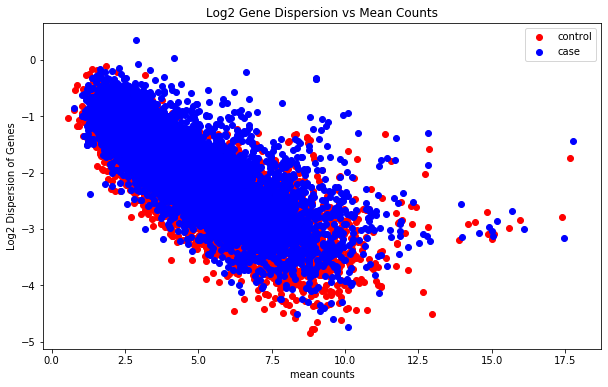

In [73]:
xs = [control_mean_counts, case_mean_counts]
ys = [np.log2(disp_control), np.log2(disp_case)]
colors = ['r', 'b']
legend_labels = ['control', 'case']

plt.figure(figsize=(10, 6))
for i in range(2):
    plt.scatter(xs[i], ys[i], c = colors[i], label=legend_labels[i])

plt.xlabel("mean counts")
plt.ylabel("Log2 Dispersion of Genes")
plt.title("Log2 Gene Dispersion vs Mean Counts")
plt.legend()
plt.show()

### Part B

In [74]:
case_idxs, control_idxs = np.where(labels == 1)[0], np.where(labels == 2)[0]
case_data, control_data = size_factor[:, case_idxs], size_factor[:, control_idxs]
case_mean_counts = compute_mean_counts(case_data)
control_mean_counts = compute_mean_counts(control_data)
gene_fold_change, top_pos_genes, top_neg_genes = compute_log_fold(gene_names, case_mean_counts, control_mean_counts)

In [87]:
print(top_neg_genes.keys())

dict_keys(['DIO2', 'C6orf141', 'RND1', 'AL807757.2', 'AL606970.1', 'IER3-AS1', 'AC011446.2', 'AREG', 'NR5A2', 'CCL2'])


In [77]:
print("Top most upregulated genes:\n")
for k, v in top_pos_genes.items():
    print(k, v)

Top most upregulated genes:

UNC5B 3.7835922539546663
FKBP5 3.6202071210828235
AL592146.1 3.5988409274230095
TNFAIP8L3 2.896262141478756
ANPEP 2.8478930056398513
FGD4 2.8129313923854045
MT1X 2.767813442422415
JPH2 2.7151368847609336
AL049839.2 2.6821134709702763
ZFP36 2.679218119648834


In [78]:
print("Top most down-regulated genes:\n")
for k,v in top_neg_genes.items():
    print(k, v)

Top most down-regulated genes:

DIO2 -2.3839424644234537
C6orf141 -1.78800782780098
RND1 -1.7175094468879009
AL807757.2 -1.716344094803305
AL606970.1 -1.6793480054226646
IER3-AS1 -1.654193208693536
AC011446.2 -1.6098982332646596
AREG -1.5878327103858227
NR5A2 -1.5764236438418224
CCL2 -1.4957167364035304


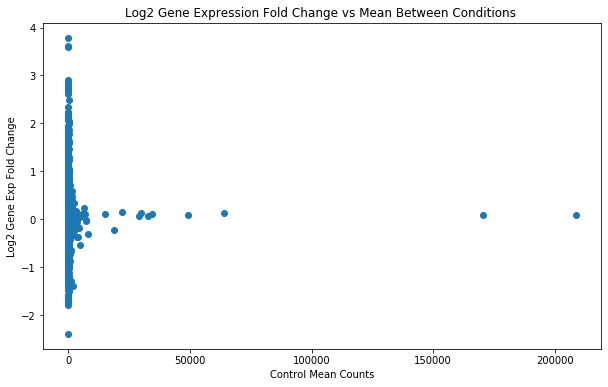

In [79]:
## PLOT 
plt.figure(figsize=(10,6))
plt.title("Log2 Gene Expression Fold Change vs Mean Between Conditions ")
plt.xlabel("Control Mean Counts")
plt.ylabel("Log2 Gene Exp Fold Change")
plt.scatter(control_mean_counts, gene_fold_change)
plt.show()
plt.close()

### Part C

In [80]:
def bh(genes, pvals, alpha):
    """(list, list, float) -> numpy array
    applies benjamini-hochberg procedure
    
    Parameters
    ----------
    genes: name of genes 
    pvalues: corresponding pvals
    alpha: desired false discovery rate
    
    Returns
    -------
    array containing gene names of significant genes.
    gene names do not need to be in any specific order.
    """

    numGenes = len(genes)
    sig_genes = []
    indices = np.argsort(pvals)
    
    for i, gene in enumerate(indices):
        
        if pvals[gene] <= (i+1)/numGenes * alpha:
            sig_genes.append(genes[indices[gene]])

    return np.asarray(sig_genes, dtype='str')

### Part D

In [90]:
## refer to Latex submission

## Question 3

In [81]:
gene_names = np.loadtxt("./provided_data/question3_data/gene_names.txt", dtype='str')

train_data = load_npz("./provided_data/question3_data/train_gene_expression.npz").toarray()
train_labels = np.load("./provided_data/question3_data/train_labels.npy")

test_data = load_npz("./provided_data/question3_data/test_gene_expression.npz").toarray()
test_labels = np.load("./provided_data/question3_data/test_labels.npy")

In [96]:
def sample_gene_dispersion(arr):
    dispersion = np.std(arr)/np.mean(arr)
    return dispersion

def get_top_gene_filter(data, n_keep = 2000):
    """Select top n_keep most dispersed genes.

    Args:
        data (n x m matrix): input gene expression data of shape num_cells x num_genes
        n_keep (int): number of genes to be kepted after filtration; default 2000

    Returns:
        filter (array of length n_keep): an array of column indices that can be used as an
            index to keep only certain genes in data. Each element of filter is the column
            index of a highly-dispersed gene in data.
    """

    numGenes = data.shape[1]
    dispersions = np.zeros(numGenes)
    for i in range(numGenes):
        currGene = data[:, i]
        dispersions[i] = sample_gene_dispersion(currGene)
    
    top_gene_idxs = np.argsort(dispersions)[::-1][:n_keep]

    return top_gene_idxs

def reduce_dimensionality_pca(filtered_train_gene_expression, filtered_test_gene_expression, n_components = 20):
    """Train a PCA model and use it to reduce the training and testing data.
    
    Args:
        filtered_train_gene_expression (n_train x num_top_genes matrix): input filtered training expression data 
        filtered_test_gene_expression (n_test x num_top_genes matrix): input filtered test expression data 
        
    Return:
        (reduced_train_data, reduced_test_data): a tuple of
            1. The filtered training data transformed to the PC space.
            2. The filtered test data transformed to the PC space.
    """
    
#     pipeline = make_pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
    
    data = np.vstack((filtered_train_gene_expression, filtered_test_gene_expression))
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
#     scaled_train_data = scaler.fit_transform(filtered_train_gene_expression)

    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)

#     reduced_train_data = pca.fit_transform(scaled_train_data)
    
    numTrain = len(filtered_train_gene_expression)
    reduced_train_data = reduced_data[:numTrain, :]
    reduced_test_data = reduced_data[numTrain:, :]

#     scaled_test_data = scaler.fit_transform(filtered_test_gene_expression)
#     reduced_test_data = pca.fit_transform(scaled_test_data)
    
    return (reduced_train_data, reduced_test_data)


def plot_transformed_cells(reduced_train_data, train_labels):
    """Plot the PCA-reduced training data using just the first 2 principal components.
    
    Args:
        reduced_train_data (n_train x num_components matrix): reduced training expression data
        train_labels (array of length n_train): array of cell type labels for training data
        
    Return:
        None

    """
    ## Keep top-N components explaining for x% of variance
    x1, x2 = reduced_train_data[:, 0], reduced_train_data[:, 1]

    ## 2D PCA Analysis
    targets = list(set(list(train_labels)))
    colors = np.random.rand(len(targets),3)

    plt.figure()
    plt.figure(figsize=(10,8))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.xlabel('Principal Component - 1',fontsize=20)
    plt.ylabel('Principal Component - 2',fontsize=20)
    plt.title("2D Principal Component Analysis",fontsize=20)
    
    for target, color in zip(targets,colors):
        indicesToKeep = np.where(train_labels == target)
        plt.scatter(x1[indicesToKeep], x2[indicesToKeep], c = color, s = 50)

    plt.legend(targets,prop={'size': 15})
    plt.show()
    plt.close()
    
    return


def train_and_evaluate_svm_classifier(reduced_train_data, reduced_test_data, train_labels, test_labels):
    """
    Train and evaluate a simple SVM-based classification pipeline.
    
    Before passing the data to the SVM module, this function scales the data such that the mean
    is 0 and the variance is 1.
    
    Args:
        reduced_train_data (n_train x num_components matrix): reduced training expression data
        train_labels (array of length n_train): array of cell type labels for training data
        
    Return:
        (classifier, score): a tuple consisting of
            1. classifier: the trained classifier
            2. The score (accuracy) of the classifier on the test data.

    """
    ## encode test labels to numbers?

    clf = SVC()
    clf.fit(reduced_train_data, train_labels)
    clf_preds = clf.predict(reduced_test_data)

    test_accuracy = accuracy_score(clf_preds, test_labels)
    
    return (clf, test_accuracy)

### Part A

In [97]:
top_genes = get_top_gene_filter(train_data)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


### Part B

In [98]:
filtered_train_gene_expression = train_data[:, top_genes]
filtered_test_gene_expression = test_data[:, top_genes]

reduced_train_data, reduced_test_data = reduce_dimensionality_pca(filtered_train_gene_expression, filtered_test_gene_expression)

### Part C

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

<Figure size 432x288 with 0 Axes>

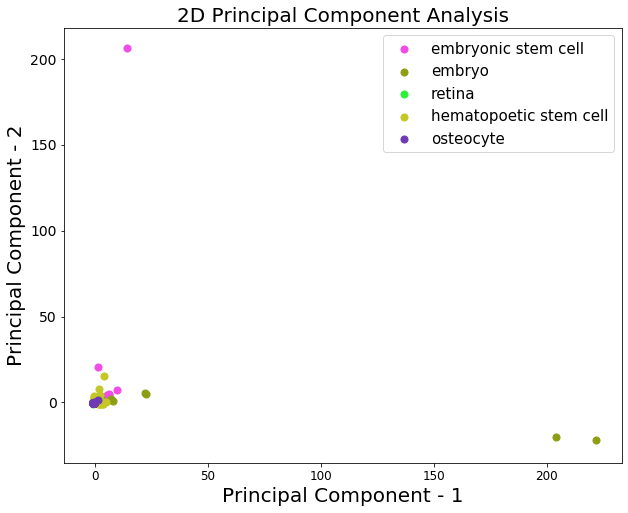

In [99]:
plot_transformed_cells(reduced_train_data, train_labels)

### Part D

In [100]:
model, test_acc = train_and_evaluate_svm_classifier(reduced_train_data, reduced_test_data, train_labels, test_labels)
print("Test Accuracy:", test_acc)

Test Accuracy: 0.5149253731343284


### Part E

In [101]:
if __name__ == "__main__":
    
    mode = "svm_pipeline"
    if mode == "svm_pipeline":
        top_genes = get_top_gene_filter(train_data)
        
        filtered_train_gene_expression = train_data[:, top_genes]
        filtered_test_gene_expression = test_data[:, top_genes]

        reduced_train_data, reduced_test_data = reduce_dimensionality_pca(filtered_train_gene_expression, filtered_test_gene_expression)
        
        model, test_acc = train_and_evaluate_svm_classifier(reduced_train_data, reduced_test_data, train_labels, test_labels)
        
        print("Training accuracy: %.3f"%model.score(reduced_train_data, train_labels))
        print("Test accuracy: %.3f"%test_acc)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Training accuracy: 0.807
Test accuracy: 0.533
